## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set()

import pandas as pd

import time

import random

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [2]:
import sys
sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")

import manifolder as mr
from manifolder import helper as mh


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
# load the data
# note, you must have started the notebook in the 

print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [4]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [5]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []

df.values[0,:]

for i in range(snippet_len,data_raw.shape[0]+1,snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]
    
    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    # print('snippet size',snippet.shape,'with goal',goal)
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append(0)
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append(1)
    else:
        assert False, 'value of goal not understood'

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list



random.shuffle(zs_0)
random.shuffle(zs_1)

shorten_data = False

if shorten_data:
    zs_0 = zs_0[:10]
    zs_1 = zs_1[:10]

zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))


\done!
	 len(zs_0): 47
	 len(zs_1): 57
	 len(zs): 104


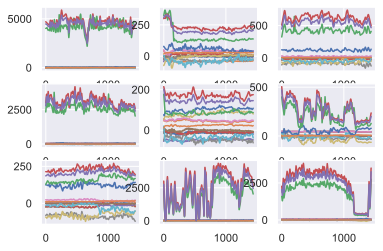

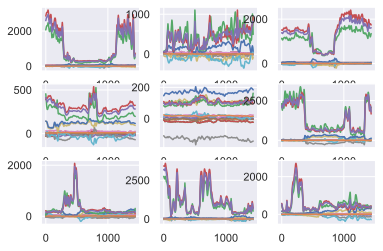

In [6]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(zs_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(zs_1[i])
    
plt.show()

In [ ]:
# data has been parsed, now run Manifolder

H = 80
step_size = 10
nbins = 10
ncov = 20

start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(H=H,step_size=step_size,nbins=nbins, ncov=ncov)

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(zs, parallel=False, use_dtw=True, dtw_stack=True, dtw_stack_dims=(1,))

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


In [ ]:
# this will dump the dtw matrix calculated in manifolder.fit_transform() into a file
import pickle
try:
    f = open("dtw_distmat_snippets_dim_5.pickle", 'w+b')
    pickle.dump(manifolder.dtw_distmat, f)
    print("dumped dtw distance matrix")
finally:
    f.close()


In [7]:
# this will read the dtw matrix from the file
import pickle
try:
    #dtw_distmat.pickle is compressed and split into 100MB zip files in Github,
    # unzipped it is 1.5GB
    f = open("dtw_distmat_snippets_dim_5.pickle", 'rb')
    dtw_distmat_dim_5 = pickle.load(f)
finally:
    f.close()
    
print(dtw_distmat_dim_5.shape)

(104, 104)


In [13]:
import sklearn

test_size = .33
val_size = 0

# snippet_label = manifolder.snip_number
num_snips_0 = int(len(zs_0))
num_snips_1 = int(len(zs_1))

num_runs = 100

cms = []
for i in range(num_runs):
    snip_indices_0 = np.random.permutation(num_snips_0)
    snip_indices_1 = np.random.permutation(num_snips_1) + num_snips_0

    n_train_0 = int((1-test_size-val_size)*num_snips_0)
    n_val_0 = int(val_size*num_snips_0)
    snip_train_0 = snip_indices_0[0:n_train_0]
    snip_val_0 = snip_indices_0[n_train_0:n_train_0+n_val_0]
    snip_test_0 = snip_indices_0[n_train_0+n_val_0: num_snips_0]

    n_train_1 = int((1-test_size-val_size)*num_snips_1)
    n_val_1 = int(val_size*num_snips_1)
    snip_train_1 = snip_indices_1[0:n_train_1]
    snip_val_1 = snip_indices_1[n_train_1:n_train_1+n_val_1]
    snip_test_1 = snip_indices_1[n_train_1+n_val_1: num_snips_1]

    # print(type(locallabel))
    # X_train = Psi[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1))),:]
    # y_train = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1)))]
    y_train = np.array(locallabel)[np.array(np.concatenate((snip_train_0, snip_train_1)))]
    # X_val = Psi[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1))),:]
    # y_val = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1)))]
    y_val = np.array(locallabel)[np.array(np.concatenate((snip_val_0, snip_val_1)))]
    # X_test = Psi[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1))),:]
    # y_test = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1)))]
    y_test = np.array(locallabel)[np.array(np.concatenate((snip_test_0, snip_test_1)))]
    # specify full dtw matrix
    dist_full = dtw_distmat_dim_5

    # extract the indices for train and test
    train_idx = np.array(np.concatenate((snip_train_0, snip_train_1)))
    test_idx = np.array(np.concatenate((snip_test_0, snip_test_1)))

    # specify distance matrix for train only
    dist_train = np.zeros((train_idx.shape[0], train_idx.shape[0]))

    for i1 in range(dist_train.shape[0]):
        v1 = train_idx[i1]
        for j1 in range(i1+1, dist_train.shape[0]):
            v2 = train_idx[j1]
            dist_train[i1,j1] = dist_full[v1,v2]
            dist_train[j1,i1] = dist_full[v2,v1]

    inds = np.argsort(dist_train,axis=1) # sort every row and assign index based on original placement in matrix


    percentCorrect = np.zeros(25)
    for knn in range(1,25):
        predict_class = np.median(y_train[inds[:,1:knn+1]],axis=1) # Could replace with "is there a label" or class_weight
        predict_class = predict_class.astype(int) 
        CM = sklearn.metrics.confusion_matrix(y_train.astype(int), predict_class )
        percentCorrect[knn] = CM[1,1]/np.sum(CM[:,1])

    print(percentCorrect)

    knn = np.argmax(percentCorrect)
    print(knn)

    # specify distance matrix for test only
    dist_test = np.zeros((test_idx.shape[0], train_idx.shape[0]))
    print(dist_test.shape)

    for i1 in range(dist_test.shape[0]):
        v1 = test_idx[i1]
        for j1 in range(dist_train.shape[0]):
            v2 = train_idx[j1]
            dist_test[i1,j1] = dist_full[v1,v2]

    inds = np.argsort(dist_test,axis=1)

    predict_class = np.median(y_train[inds[:,0:knn]],axis=1)
    predict_class_f = predict_class
    predict_class = predict_class.astype(int) 

    CM = sklearn.metrics.confusion_matrix(y_test.astype(int), predict_class )
    cms.append(CM)
print('DTW Confusion:')
print(cms[0])


[0.     0.8387 0.9048 0.9118 0.8889 0.8788 0.8571 0.8182 0.8667 0.7778
 0.871  0.7209 0.7297 0.7111 0.7209 0.7045 0.7381 0.6809 0.7209 0.6809
 0.6957 0.6957 0.6957 0.6875 0.7111]
3
(35, 69)
[0.     0.8108 0.96   0.8571 0.8889 0.8333 0.8387 0.75   0.7778 0.7317
 0.75   0.6875 0.7317 0.6875 0.6957 0.6667 0.6957 0.6809 0.6957 0.6875
 0.6875 0.6296 0.6471 0.6111 0.6111]
2
(35, 69)
[0.     0.8125 0.96   0.8571 0.8966 0.8462 0.8571 0.7949 0.8056 0.775
 0.8378 0.8049 0.8158 0.6939 0.7111 0.7234 0.7174 0.6939 0.7083 0.6939
 0.6875 0.6471 0.6471 0.6182 0.6226]
2
(35, 69)
[0.     0.7097 0.8095 0.7941 0.7931 0.7838 0.8571 0.7778 0.8    0.6977
 0.725  0.7111 0.7317 0.6889 0.75   0.6531 0.6977 0.62   0.617  0.6038
 0.625  0.6078 0.5957 0.6038 0.5745]
6
(35, 69)
[0.     0.7241 0.85   0.75   0.7931 0.7714 0.8276 0.75   0.7879 0.75
 0.7647 0.7179 0.7297 0.725  0.75   0.7436 0.7714 0.7143 0.7568 0.7143
 0.7368 0.7073 0.7    0.6905 0.725 ]
2
(35, 69)
[0.     0.8    0.84   0.8438 0.8077 0.8438 0.8667 0.8

 0.6275 0.6182 0.6182 0.5965 0.6071]
2
(35, 69)
[0.     0.8182 0.913  0.7879 0.8846 0.7778 0.7931 0.7429 0.7576 0.7568
 0.7879 0.75   0.7778 0.7436 0.7568 0.7045 0.7368 0.6818 0.6842 0.6512
 0.65   0.6    0.6429 0.549  0.5745]
2
(35, 69)
[0.     0.7714 0.8333 0.8    0.8182 0.7632 0.7419 0.7179 0.7742 0.6842
 0.7273 0.6585 0.6857 0.6522 0.6341 0.6226 0.6364 0.6346 0.64   0.6111
 0.6122 0.6    0.6531 0.569  0.5789]
2
(35, 69)
[0.     0.7647 0.9474 0.8387 0.92   0.8667 0.8889 0.7941 0.8966 0.7714
 0.8125 0.7179 0.7222 0.6829 0.6923 0.6383 0.6222 0.66   0.6735 0.68
 0.6735 0.6735 0.6735 0.66   0.6531]
2
(35, 69)
[0.     0.7568 0.84   0.8158 0.8387 0.7838 0.8438 0.7368 0.8125 0.6889
 0.7429 0.6875 0.725  0.6275 0.6667 0.5962 0.6667 0.6364 0.6667 0.6034
 0.6078 0.5645 0.569  0.5538 0.5556]
6
(35, 69)
[0.     0.7576 0.8696 0.7778 0.8125 0.7778 0.8276 0.75   0.7647 0.7073
 0.7714 0.6905 0.7105 0.6364 0.6512 0.6809 0.6889 0.6667 0.6596 0.6667
 0.6596 0.64   0.6327 0.6154 0.6154]
2
(35, 69)
[0. 

 0.6739 0.6596 0.6596 0.6596 0.6596]
4
(35, 69)
DTW Confusion:
[[12  4]
 [ 7 12]]


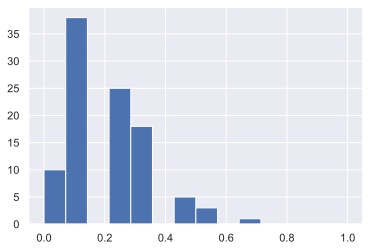

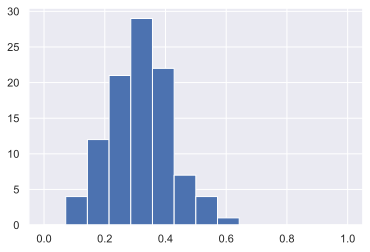

In [15]:
falsePositive = []
falseNegative = []
total = np.sum(cms[0], axis=0)
for cm in cms:
    falsePositive.append(cm[0,1]/total[1])
    falseNegative.append(cm[1,0]/total[0])
#print(falsePositive)
#print(falseNegative)
plt.hist(falsePositive, bins=np.linspace(0,1, num=15))#, bins = range(0,14))
plt.show()
plt.hist(falseNegative, bins=np.linspace(0,1, num=15))#, bins = range(0,14))
plt.show()

In [ ]:
# this will read the dtw matrix from the file (all dimensions used from original data)
import pickle
try:
    #dtw_distmat.pickle is compressed and split into 100MB zip files in Github,
    # unzipped it is 1.5GB
    f = open("dtw_distmat.pickle", 'rb')
    manifolder.dtw_distmat = pickle.load(f)
finally:
    f.close()

In [ ]:
print(manifolder.dtw_distmat.shape)

In [ ]:
start_time = time.time()

numClusters = 7

manifolder._clustering(numClusters=numClusters, kmns=False, distance_measure="dtw")  # display
print(manifolder.IDX.shape)
elapsed_time = time.time() - start_time
print('\n\t Program Executed for k means clustering in', str(np.round(elapsed_time, 2)), 'seconds')

In [ ]:
# clustering data for k-means...

IDX = manifolder.IDX
cluster_lens = mh.count_cluster_lengths(IDX)

# cluster_lens is a dictionary a dictonary, where each key is the cluster number (0:6),
# and the values are a list of cluster lengths

mh.show_cluster_lengths(cluster_lens)


In [ ]:
# in this case, index goes from 0 to 6 ...
# can also have outlier groups in kmeans, need to check for this

print(IDX.shape)
print(np.min(IDX))
print(np.max(IDX))

IDX_max = np.max(IDX)


In [ ]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)

M_z0 = mh.make_transition_matrix(IDX[manifolder.snip_number<z_breakpoint])
M_z1 = mh.make_transition_matrix(IDX[manifolder.snip_number>=z_breakpoint])

print('\n z0 transition matrix:')
print(M_z0)

print('\n z1 transition matrix:')
print(M_z1)

In [ ]:
z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)

z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(len(IDX),1), 1)
z_downsample = np.append(z_downsample, IDX.reshape(len(IDX),1), 1)
    
z_downsample.shape

In [ ]:
filename = "astro_dtw_k="+str(numClusters)
filename += "_stack="
if stack
filename += ".csv"

np.savetxt('astro_dtw_k='+str(numClusters)+'.csv', z_downsample, delimiter=',', fmt='%f')

### TODO:

After running `fit_transform()`, use kmeans to label clusters withing all the snippets

Create a transition matrix for each snippet; the zs_0 and zs_1 should have distincively different matrices, which can be used to categorize the snippet



In [ ]:
### _cluster() function, local to make it easier to work on
### ... note, all the individual clusters should be marked invidually?
### but the original kmeans run run all of them together?
###

# Configuration
numClusters = 7  # NOTE, this was previously 14 (too many!)
intrinsicDim = manifolde.Dim  # can be varied slightly but shouldn't be much larger than Dim

## Clusters
# IDX = kmeans(Psi(:, 1:intrinsicDim), numClusters)

# Python kmeans see
# https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.cluster.vq.kmeans.html
# scipy.cluster.vq.kmeans(obs, k_or_guess, iter=20, thresh=1e-05)
#
#  note, python expects each ROW to be an observation, looks the same a matlap
#

print('running k-means')

kmeans = KMeans(n_clusters=numClusters).fit(manifolder.Psi[:, :intrinsicDim])
IDX = kmeans.labels_

# TODO decide how to plot multiple snips
# think that x_ref[1,:] is just
for snip in range(len(self.z)):
    if snip == 0:
        x = self.z[snip][0, :]
        xref1 = x[::self.stepSize]  # downsample, to match the data steps
    else:
        x = self.z[snip][0, :]
        x = x[::self.stepSize]
        xref1 = np.append(xref1, x)

print(xref1.shape)

xs = manifolder.Psi[:, 0]
ys = manifolder.Psi[:, 1]
zs = manifolder.Psi[:, 2]

# normalize these to amplitude one?
print('normalizing amplitudes of Psi in Python ...')
xs /= np.max(np.abs(xs))
ys /= np.max(np.abs(ys))
zs /= np.max(np.abs(zs))

# xs -= np.mean(xs)
# ys -= np.mean(ys)
# zs -= np.mean(zs)

# xs /= np.std(xs)
# ys /= np.std(ys)
# zs /= np.std(zs)

print(xs.shape)

lim = 2000
val = xref1[:lim]
idx = manifolder.IDX[:lim]

plt.figure(figsize=[15, 3])

plt.plot(xref1[:lim], color='black', label='Timeseries')
# plt.plot(xs[:lim], linewidth=.5, label='$\psi_0$')
# plt.plot(ys[:lim], linewidth=.5, label='$\psi_1$')
# plt.plot(zs[:lim], linewidth=.5, label='$\psi_2$')

plt.plot(xs[:lim], linewidth=.5, label='psi_0')
plt.plot(ys[:lim], linewidth=.5, label='psi_1')
plt.plot(zs[:lim], linewidth=.5, label='psi_2')

plt.plot(idx / np.max(idx) + 1, linewidth=.8, label='IDX')

plt.legend()

# rightarrow causes an image error, when displayed in github!
# plt.xlabel('Time $ \\rightarrow $')
plt.xlabel('Time')
plt.ylabel('Value')

# plt.gca().autoscale(enable=True, axis='both', tight=None )
# plt.gca().xaxis.set_ticklabels([])
# plt.gca().yaxis.set_ticklabels([])

plt.title('Example Timeseries and Manifold Projection')

print('done')

###
### additional parsing, for color graphs
###
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')

r = xs[:lim]
g = ys[:lim]
b = zs[:lim]

# prevent the jump in data value
r[:self.H] = r[self.H]
g[:self.H] = g[self.H]
b[:self.H] = b[self.H]

r -= np.min(r)
r /= np.max(r)

g -= np.min(g)
g /= np.max(g)

b -= np.min(b)
b /= np.max(b)

plt.figure(figsize=[15, 3])

for i in range(lim - 1):
    col = [r[i], g[i], b[i]]
    plt.plot([i, i + 1], [val[i], val[i + 1]], color=col)

plt.title('data, colored according to Psi (color three-vector)')
plt.xlabel('Time')
plt.ylabel('Value')

plt.show()


In [ ]:
# clustering data ...

IDX = manifolder.IDX

cluster_lens = mh.count_cluster_lengths(IDX)

# cluster_lens is a dictionary a dictonary, where each key is the cluster number (0:6),
# and the values are a list of clusner lengths

mh.show_cluster_lens(cluster_lens)


### Graph Transition (Markov) Matrix

The system can be though of as in one particular "state" (cluster value) at any given time.  This state $S$ can be though of as a column vector with $C$ dimensions, similar to states in quantum mechanic, where the column vector plays the role of the transition matrix.

Time evolution is this given by the tranistion matrix $M$, which is a Markov matrix (all columns sum to one, to preserve probability).  In this case, we have

$$
S_{n+1} = M @ S_n 
$$

Where the $@$ symbol is used to explicitly denote matrix multiplication.

Since most clusters with transition to themselves, the diagonal values of the matrix can be quite high, and are typically removed.  Thus, for visualization, we remove the diagonal elements of the matrix.

In [ ]:
# in this case, index goes from 0 to 6 ... 
# can also have outlier groups in kmeans, need to check for this

print(IDX.shape)
print(np.min(IDX))
print(np.max(IDX))

IDX_max = np.max(IDX)


In [ ]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)


In [ ]:
# reorder transition matrix, from most to least common cluster
# diagonal elements monotonically decreasing

IDX_ordered = mh.reorder_cluster(IDX, M)

M = mh.make_transition_matrix(IDX_ordered)
print('\n transition matrix, ordered:')
print(M)

mh.image_M(M)


In [ ]:
# remove diagonal, and make markov, for display

print('transition matrix, diagonal elements removed, normalized (Markov)')

np.fill_diagonal(M, 0)  # happens inplace
M = mh.make_matrix_markov(M)

print(M)
mh.image_M(M, 1)
